In [3]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Poisson2D(Problem):
    """
    Solves the 2D Poisson equation
        - u_xx - u_yy = f(x,y)
    on the domain [0,1] with Dirichlet boundary conditions u = 0 on ∂Ω.

    We choose f(x,y) such that the exact solution is:
        u(x,y) = sin(πx)sin(πy)
    which implies f(x,y) = 2π²sin(πx)sin(πy).
    """

    @staticmethod
    def init_params(f_coeff=2 * jnp.pi ** 2, sd=0.1):
        # 'dims': (ud, xd) => u is scalar (ud=1) and x is 2D (xd=2)
        static_params = {
            "dims": (1, 2),
            "f_coeff": f_coeff,  # coefficient in the forcing function f(x,y)
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # --- Physics loss: sample interior points ---
        # x_batch_phys: an array of shape (n_phys, 2)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, (0, 0)), # u_xx
            (0, (1, 1)), # u_yy
        )

        return [[x_batch_phys, required_ujs_phys],]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, y, tanh = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh
        u = tanh((x)/sd) * tanh((1-x)/sd) * tanh((y)/sd) * tanh((1-y)/sd) * u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        # --- Physics loss ---
        # For the physics group, the constraints have been replaced with the evaluated quantities:
        # [x_batch_phys, u_xx, u_yy]
        x_phys, u_xx, u_yy = constraints[0]
        x, y = x_phys[:, 0:1], x_phys[:,1:2]

        # Compute the forcing term f(x,y) = 2π² sin(πx) sin(πy)
        f_coeff = all_params["static"]["problem"]["f_coeff"]
        f_val = f_coeff * jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)

        # The physics residual is: u_xx + u_yy + f(x,y)
        phys_residual = u_xx + u_yy + f_val

        return jnp.mean(phys_residual ** 2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x, y = x_batch[:, 0:1], x_batch[:,1:2]
        u = jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)
        return u
    

[INFO] 2025-04-14 15:29:34 - <fbpinns.constants.Constants object at 0x7dbba0e94ce0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.Poisson2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (0.0, 3.0)}
network: <clas

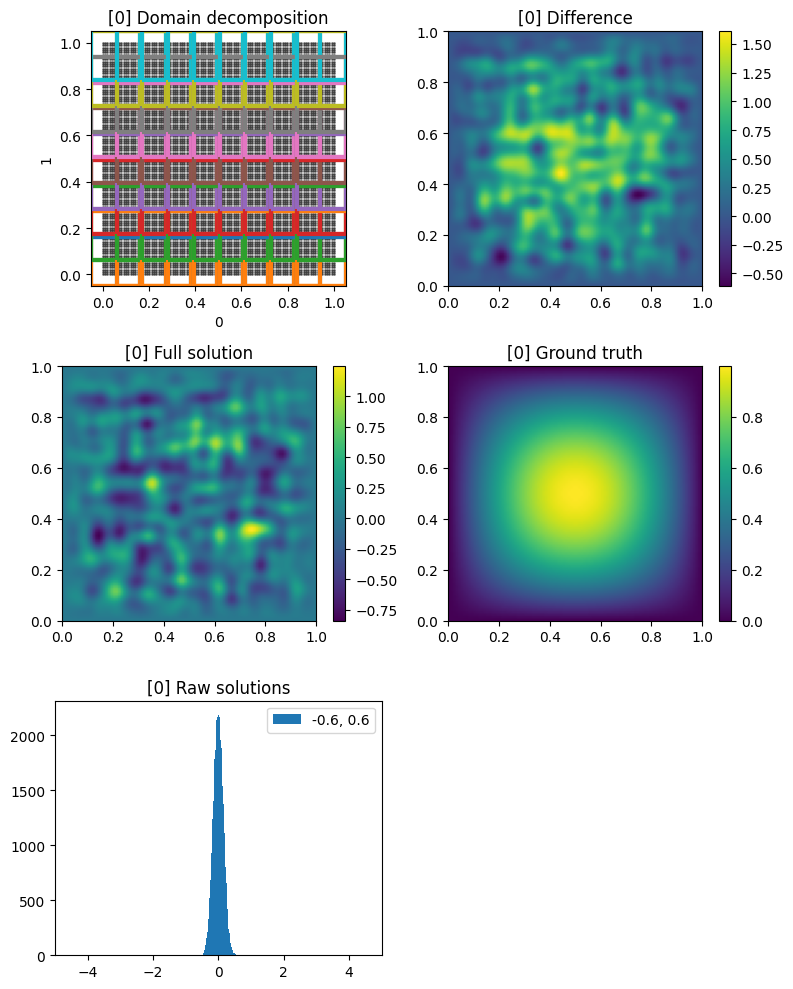

[INFO] 2025-04-14 15:29:40 - [i: 1000/20000] loss: 75.8393 rate: 227.8 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:41 - [i: 2000/20000] loss: 20.2644 rate: 1278.4 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:41 - [i: 3000/20000] loss: 8.8817 rate: 1278.9 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:42 - [i: 4000/20000] loss: 4.8854 rate: 1278.0 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:43 - [i: 5000/20000] loss: 2.7947 rate: 1279.1 elapsed: 0.00 hr test
(10000, 2) (10000, 1) (10000, 1) (73984, 1) (73984, 1) (73984, 1) (10000, 2) (100, 100)
True


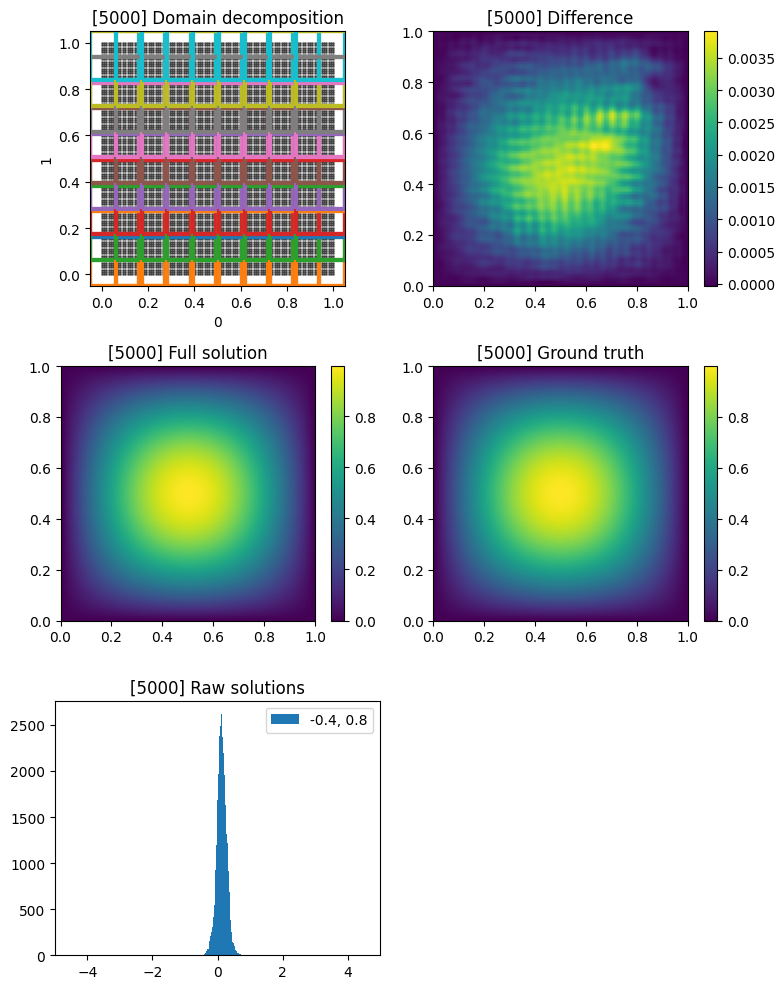

[INFO] 2025-04-14 15:29:45 - [i: 6000/20000] loss: 1.6102 rate: 1278.1 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:46 - [i: 7000/20000] loss: 1.0831 rate: 1278.6 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:46 - [i: 8000/20000] loss: 0.8771 rate: 1278.6 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:47 - [i: 9000/20000] loss: 0.7089 rate: 1278.2 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:48 - [i: 10000/20000] loss: 2.1664 rate: 1278.6 elapsed: 0.00 hr test
(10000, 2) (10000, 1) (10000, 1) (73984, 1) (73984, 1) (73984, 1) (10000, 2) (100, 100)
True


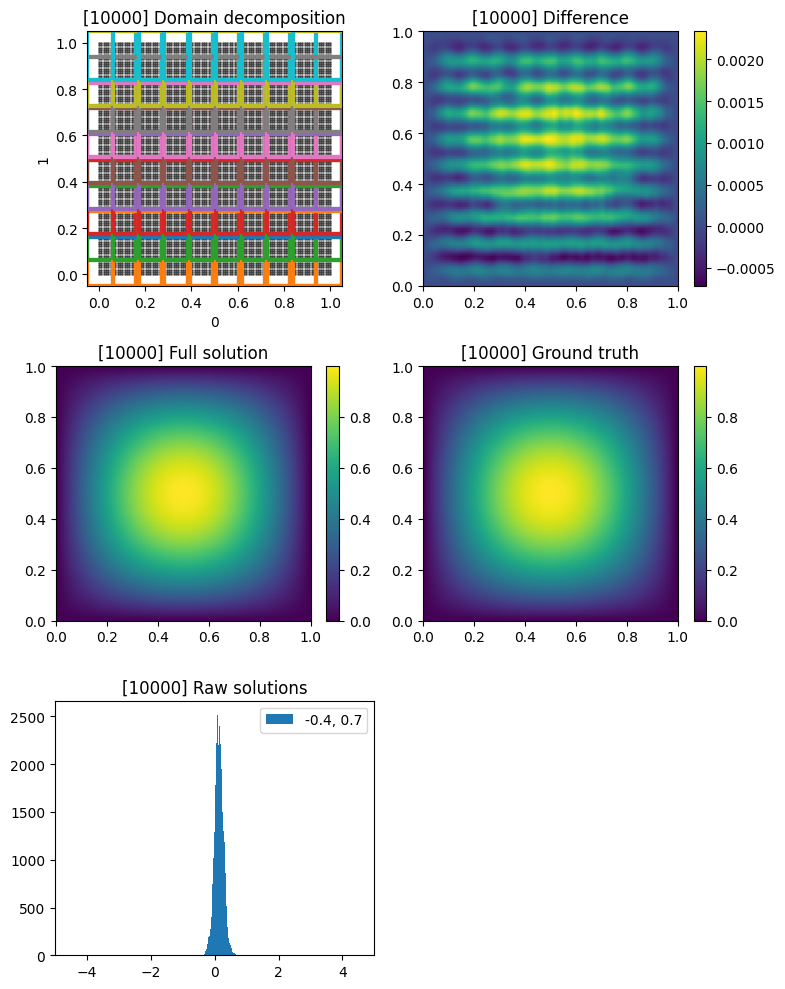

[INFO] 2025-04-14 15:29:50 - [i: 11000/20000] loss: 2.0821 rate: 1278.7 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:50 - [i: 12000/20000] loss: 0.2767 rate: 1278.1 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:51 - [i: 13000/20000] loss: 0.9651 rate: 1279.3 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:52 - [i: 14000/20000] loss: 0.7513 rate: 1279.6 elapsed: 0.00 hr test
[INFO] 2025-04-14 15:29:53 - [i: 15000/20000] loss: 1.6745 rate: 1278.2 elapsed: 0.01 hr test
(10000, 2) (10000, 1) (10000, 1) (73984, 1) (73984, 1) (73984, 1) (10000, 2) (100, 100)
True


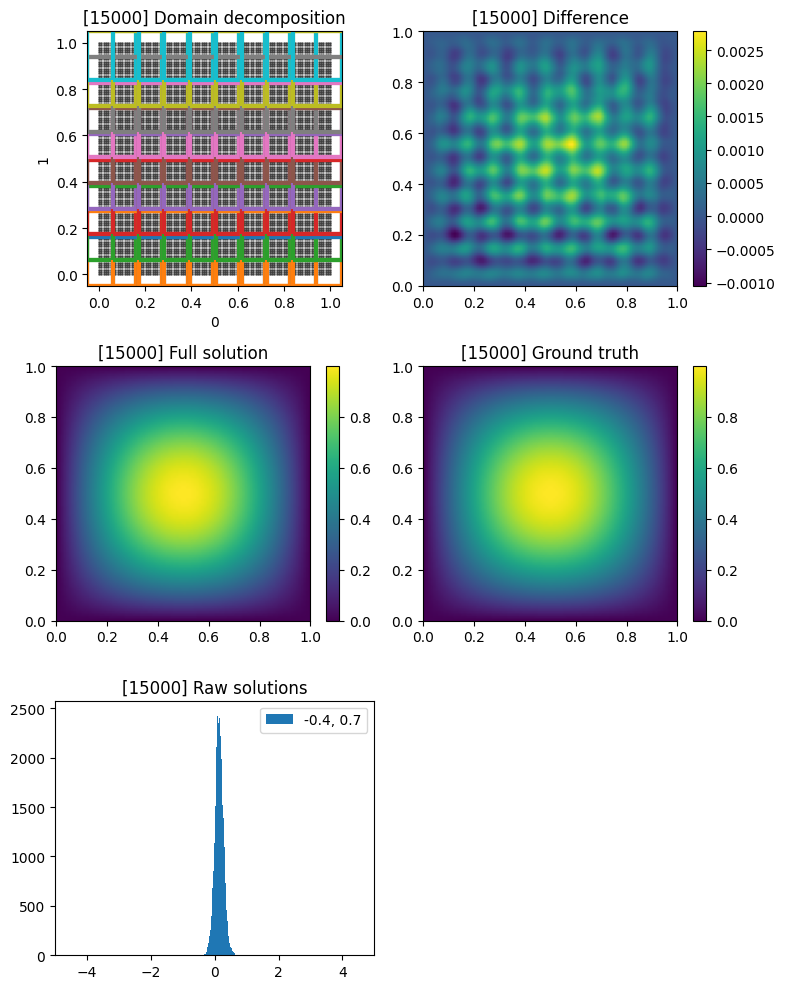

[INFO] 2025-04-14 15:29:54 - [i: 16000/20000] loss: 0.3108 rate: 1278.7 elapsed: 0.01 hr test
[INFO] 2025-04-14 15:29:55 - [i: 17000/20000] loss: 1.7203 rate: 1279.6 elapsed: 0.01 hr test
[INFO] 2025-04-14 15:29:56 - [i: 18000/20000] loss: 0.9033 rate: 1278.4 elapsed: 0.01 hr test
[INFO] 2025-04-14 15:29:57 - [i: 19000/20000] loss: 0.4521 rate: 1278.3 elapsed: 0.01 hr test
[INFO] 2025-04-14 15:29:58 - [i: 20000/20000] loss: 3.6557 rate: 1278.6 elapsed: 0.01 hr test
(10000, 2) (10000, 1) (10000, 1) (73984, 1) (73984, 1) (73984, 1) (10000, 2) (100, 100)
True


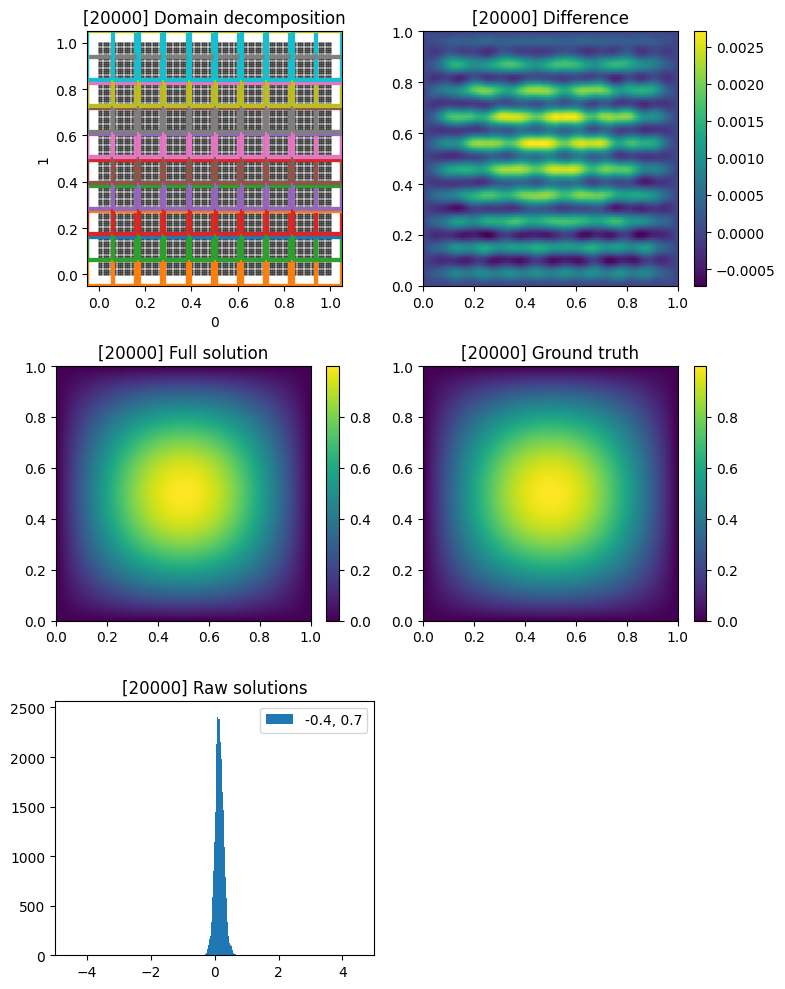

[INFO] 2025-04-14 15:29:58 - [i: 20000/20000] Training complete


In [4]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import ChebyshevKAN, FCN, ChebyshevAdaptiveKAN
from fbpinns.schedulers import LineSchedulerRectangularND, PointSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer

subdomain_xs=[np.linspace(0,1,10), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=Poisson2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0., 3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 10, 1),
    # ),
    # network=ChebyshevAdaptiveKAN,
    network=ChebyshevKAN,
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=10,
        kind=1
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    # scheduler = PointSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.5, 0.5],
    # ),
    # First element: interior sampling shape for the physics loss (here 200 x 200 points)
    # Second element: boundary sampling shapes; for 2D, we need 4 tuples (one for each boundary)
    ns=((100, 100),),
    # n_test provides the test sampling shape for the interior (here also 200 x 200)
    n_test=(100, 100),
    n_steps=20000,
    clear_output=False,
)

run = FBPINNTrainer(c)
# run = PINNTrainer(c)
all_params = run.train()